# Introdução

A Electronic House é um comercio online ( e-commerce ) de produtos de informática
para casas e escritórios. Os clientes podem comprar mouses, monitores, teclados,
computadores, laptops, cabos HDMI, fones de ouvido, cameras webcam, entre
outros, através de um site online e recebem os produtos no conforto de suas casas.

Os produtos não são vendidos somente no Brasil, a Eletronic House está presente
em diversos países da Europa e da América do Norte.

O Diretor de Produtos Global pediu ao Head de Design que desenvolvesse uma
nova forma de finalizar a compra com cartão de crédito, sem a necessidade do
cliente preencher manualmente todas as informações do cartão e que funcionasse
em todos os países.

Depois de meses desenvolvendo esse dispositivo, o time de Desenvolvimento
Backend entregou uma solução de pagamentos, na qual 90% das informações do
formulário eram preenchido automaticamente.

O Head de Designer gostaria de medir a efetividade do novo dispositivo de
preenchimento automático dos dados do cartão de crédito na página de vendas e
reportar os resultados ao Diretor de Produtos Global, para concluir se a nova forma
de pagamento é realmente melhor do que a antiga.

As duas páginas foram colocadas no ar e durante alguns meses e o time de Front-
End desenvolveu uma automação que atribui um rótulo para cada cliente,
mostrando qual a página de vendas aquele determinado cliente estava visualizando.
Todos esses dados foram armazenados em um banco de dados e podem ser
acessados pelos times da Electronic House.

## Desafio

Depois de alguns meses de experimento, o time de Designers da Electronic House,
precisa avaliar os resultados do experimento realizado, a fim de concluir qual era a
forma de pagamento mais eficaz.

Porém, o time não possui as habilidades necessárias para avaliar os dados e
concluir o experimento. Nesse contexto, você foi contratado como Cientista de
Dados para ajudar o time de Designers a validar a efetividade do novo meio de
pagamento, com mais confiança e rigidez na análise.

Qual a melhor forma de pagamento: Preenchimento Manual ou Automático do
formulário de dados do cartão de crédito?

# 0.1 IMPORTS

In [54]:
import math
import pandas as pd
import numpy as np
import pingouin as pg

from scipy import stats

from statsmodels.stats import api as sm

## 0.2 Helper Functions

In [59]:
#define F-test function
def f_test(x, y, alpha):
    """
    x: amostra com maior variancia
    y: amostra com menor variancia
    """
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    
    fc_upper = stats.f.ppf(1-(alpha/2), dfn, dfd)
    fc_lower = stats.f.ppf(alpha/2, dfn, dfd)

    print(f'F estatístico: {f}')
    if (f < fc_lower) or (f > fc_upper):
        print('Hipótese nula rejeitada: Variâncias não são próximas')
    else:
        print('Não há evidências suficientes, hipótese nula não pode ser rejeitada')

# 1.0 Load dataset

In [2]:
data_raw = pd.read_csv('../datasets/ab_testing.csv')

In [3]:
data_raw.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [4]:
data_raw.shape

(45883, 8)

# 2.0 Design de Experimentos

## 2.1 Formulação das Hipóteses

H0: A média de faturamento não é afetada pela página.

H1: A média de faturamento da página nova é maior.

## 2.2 Parâmetros do Experimento

In [7]:
df_control = data_raw[data_raw['group'] == 'GRP B']
df_treatment = data_raw[data_raw['group'] == 'GRP A']

print(f'Control Group Size: {df_control.shape[0]}')
print(f'Treatment Group Size: {df_treatment.shape[0]}')

Control Group Size: 22874
Treatment Group Size: 23009


A métrica definida foi GMV (Gross Margin Revenue).

Com base no GMV médio do grupo controle (considerado como a média histórica), estima-se uma melhora de 5% com a nova feature desenvolvida para pagamentos.

In [102]:
init_metric = df_control['spent'].mean()
std_metric = df_control['spent'].std()

end_metric = init_metric*(1.05)

In [103]:
# nível de confiança
confidence_level = 0.95

# nível de significância
significance_level = 0.05

# tamanho do efeito - Glass' Delta
effect_size = (end_metric - init_metric)/std_metric

# poder estatístico
power = 0.80

In [104]:
# sample size
sample_n = math.ceil(sm.tt_ind_solve_power(
    effect_size,
    power=power,
    alpha=significance_level
))

In [105]:
print(f'O tamanho da amostra do a ser coletado de ambos os grupos é de :{sample_n}')
print(f'Tamanho total da amostra: {2*sample_n}')

O tamanho da amostra do a ser coletado de ambos os grupos é de :3262
Tamanho total da amostra: 6524


# 3.0 Análise Descritiva dos Dados

In [70]:
df3 = data_raw.copy()

In [84]:
df3.groupby(['group', 'country']).agg({'spent': ['min', 'max'],
                          'purchases': ['min', 'mean', 'max']})

spent        purchases              
                min    max       min      mean max
group country                                     
GRP A AUS        99   8379         1  4.711462  21
      BRA        99  10480         1  4.568172  24
      CAN        99   9079         1  4.381089  21
      DEU        99  10278         1  4.414286  23
      ESP        99   8581         1  4.364948  19
      FRA        99   7781         1  4.574320  21
      GBR        99   8383         1  4.421356  20
      MEX        99   9677         1  4.570686  23
      TUR        99  11176         1  4.582730  24
      USA        99  10675         1  4.564602  25
GRP B AUS        99   7882         1  4.379648  18
      BRA        99  10478         1  4.585393  23
      CAN        99   7284         1  4.587730  17
      DEU        99   9583         1  4.584718  20
      ESP        99   8980         1  4.764523  20
      FRA        99   8981         1  4.591199  20
      GBR        99  10176         1  4.537597  24
      MEX        99   9877         1  4.531794  23
      TUR        99   8386         1  4.566016  19
      USA        99  12170         1  4.502475  30

## Verificação dos dados faltantes

In [71]:
df3.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

## Conferir flags

In [72]:
df3[['uid', 'group']].groupby(['group']).count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


## Amostragem dos grupos de tratamento e controle

In [95]:
# Control group
df_control_sample = df_control.sample(n=sample_n, random_state=12)

# Treatment group
df_treatment_sample = df_treatment.sample(n=sample_n, random_state=12)

## Cálculo da métrica de interesse

In [106]:
print('Control Mean GMV : {:.2f}'.format(df_control_sample['spent'].mean()))
print('Treatment Mean GMV : {:.2f}'.format(df_treatment_sample['spent'].mean()))

Control Mean GMV : 1887.28
Treatment Mean GMV : 1868.16


# 4.0 Teste de Hipóteses

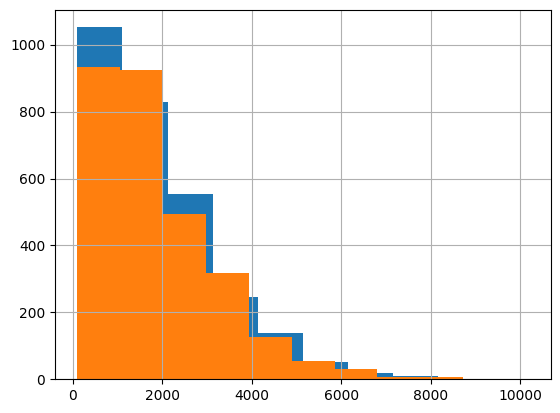

In [107]:
df_control_sample['spent'].hist()
df_treatment_sample['spent'].hist();

## Teste de Normalidade - Shapiro-Wilk

H0: Distribuição normalmente distribuída

H1: Distribuição não normal

In [108]:
_, pvalue1 = stats.shapiro(df_control_sample['spent'])
print(f'p-value control : {pvalue1}')
_, pvalue2 = stats.shapiro(df_treatment_sample['spent'])
print(f'p-value treatment: {pvalue2}')

print('\nVar control: {}'.format(np.var(df_control_sample['spent'])))
print('Var treatment: {}'.format(np.var(df_treatment_sample['spent'])))

p-value control : 1.2452401983782016e-38
p-value treatment: 1.2459505165697679e-40

Var control: 1856262.3438713101
Var treatment: 1883054.8635010624


As amostras não são normalmente distribuídas.

## Teste de Variância - F-Test

H0: Variâncias são iguais

H1: Variâncias são diferentes

In [109]:
f_test(df_control_sample['spent'], df_treatment_sample['spent'], alpha=0.05)

F estatístico: 0.9857717795965125
Não há evidências suficientes, hipótese nula não pode ser rejeitada


Não há evidências suficientes para afirmar que a variância das amostras é diferente.

## Mann-Whitney U-test (Condições paramétricas não satisfeitas)

H0: não há diferença no GMV médio das páginas

H1: o GMV média das páginas é diferente

In [110]:
statistic, pvalue = stats.mannwhitneyu(df_control_sample['spent'], df_treatment_sample['spent'])

print(f'p-value : {pvalue}')

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hipótese nula')
else:
    print('Falha ao rejeitar a hipótese nula')

p-value : 0.4832103974256091
Falha ao rejeitar a hipótese nula


Com os dados coletados não é possível afirmar que a diferença é significante.

As opções para seguir com o teste são:
* Coletar mais dados
* Melhorar o efeito aprimorando a página
* Verificar a eficácia do novo disposito por país